# Demo of Model pipeline
1. Find images with similar global descriptors
2. Cluster by covisiblity
3. Find local descriptors
4. Match to SfM model
5. Calculate pose

## Setup: Imports, Loading data
Loading data into memory. This may take some minutes.

In [1]:
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
import cv2
import time
from collections import namedtuple
import sqlite3
import read_model as rm
import nearpy

from dataset_loaders.utils import load_image
import models.netvlad_vd16_pitts30k_conv5_3_max_dag as netvlad

%matplotlib inline

In [2]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
        1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def colmap_image_to_pose(image):
    im_T_w = np.eye(4)
    im_T_w[:3, :3] = qvec2rotmat(image.qvec)
    im_T_w[:3, 3] = image.tvec
    w_T_im = np.linalg.inv(im_T_w)
    return w_T_im


In [3]:
def get_cursor(name):
    return sqlite3.connect(name).cursor()

def descriptors_from_colmap_db(cursor, image_id):
    #print('Select descriptors from image_id=%d'%image_id)
    cursor.execute('SELECT cols, data FROM descriptors WHERE image_id=?;',(image_id,))
    feature_dim, blob = next(cursor)
    desc = np.frombuffer(blob, dtype=np.uint8).reshape(-1, feature_dim)
    return desc


def keypoints_from_colmap_db(cursor, image_id):
    cursor.execute('SELECT cols, data FROM keypoints WHERE image_id=?;',(image_id,))
    cols, blob = next(cursor)
    kpts = np.frombuffer(blob, dtype=np.float32).reshape(-1, cols)
    return kpts

def get_kpts_desc(cursor, image_id):
    image_id = int(image_id)
    kpts = keypoints_from_colmap_db(cursor, image_id)[:, :2]
    desc = descriptors_from_colmap_db(cursor, image_id)
    return kpts, desc

def get_img_id(cursor, img_name):
    img_id, = next(cursor.execute('SELECT image_id FROM images WHERE name="%s";'%img_name))
    return img_id

def get_img_id_dataset(cursor, dataset_id):
    db_query_name = 'db/%d.jpg'%dataset.get_img_id(dataset_id)
    return get_img_id(cursor, db_query_name)

def kpts_to_cv(kpts, kpt_size=1.0):
    cv_kpts = []
    for i, kpt in enumerate(kpts):
        cv_kpts.append(cv2.KeyPoint(x=kpt[0], y=kpt[1], _size=kpt_size))
    return cv_kpts


In [4]:
points3d = rm.read_points3D_text('data/points3D.txt')
print('%d 3d points'%len(points3d))
#cameras = rm.read_cameras_text('data/cameras.txt')
#print('%d cameras'%len(cameras))
images = rm.read_images_text('data/images.txt')
print('%d images'%len(images))

1652687 3d points
4328 images


In [5]:
get_img = lambda i: np.array(load_image('data/AachenDayNight/images_upright/'+images[i].name))

In [6]:
database_cursor = get_cursor('data/AachenDayNight/aachen.db')
query_cursor = get_cursor('data/queries.db')

kpt_size = 1.

In [7]:
##create image clusters
t = time.time()
img_cluster = {}
for p_id in points3d.keys(): 
    img_ids = points3d[p_id].image_ids
    for img_id in img_ids:
        if img_id in img_cluster:
            img_cluster[img_id] |= set(img_ids)
        else:
            img_cluster[img_id] = set(img_ids)
t = time.time() - t
print('Found %d cluster in %d s'%(len(img_cluster), t))

Found 4328 cluster in 31 s


In [8]:
# Camera matrix
camera_matrices = {}
query_intrinsics_files = ['data/AachenDayNight/queries/day_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/queries/night_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/database_intrinsics.txt']
for file_path in query_intrinsics_files:
    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
        for line in lines:
            # Format: `image_name SIMPLE_RADIAL w h f cx cy r`
            line = line.split(' ')
            img_path = line[0]
            f = float(line[4])
            cx = float(line[5])
            cy = float(line[6])
            rad_dist = float(line[7])
            A = np.array([[f, 0, cx],[0, f, cy], [0, 0, 1]])
            camera_matrices[img_path] = {'cameraMatrix': A, 'rad_dist':rad_dist}

In [9]:
global_resolution = 256
n_images = 3

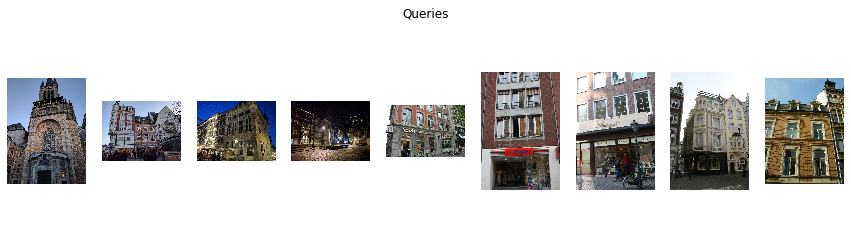

In [10]:
"""
2 day time queries
2 night time queries
2 dataset queries
"""
dataset_queries = [1, 500, 250, 2500, 4000]
path_to_queries = [
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_162905.jpg',
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_160713.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_172616.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_191152.jpg',
                   #'data/AachenDayNight/images_upright/db/1.jpg',
                   #'data/AachenDayNight/images_upright/db/500.jpg'
                  ] + ['data/AachenDayNight/images_upright/db/'+str(i)+'.jpg' for i in dataset_queries]
n_queries = len(path_to_queries)
low_res_transform = transforms.Compose([transforms.Resize(global_resolution), transforms.CenterCrop(global_resolution)])
query_imgs_high_res = [load_image(path) for path in path_to_queries]
#query_imgs_low_res = [transform(img) for img in query_imgs_high_res]
fig = plt.figure(figsize=(15,4))
plt.title('Queries')
plt.axis('off')
for i, img in enumerate(query_imgs_high_res):
    a = fig.add_subplot(1, len(query_imgs_high_res), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1. Find similar images (global descriptors)

In [11]:
model = netvlad.vd16_pitts30k_conv5_3_max_dag(weights_path='data/teacher_models/netvlad_pytorch/vd16_pitts30k_conv5_3_max_dag.pth')
model.eval()
query_global_desc = [model(transforms.ToTensor()(low_res_transform(img)).unsqueeze(0)).detach().cpu().squeeze(0).numpy() for img in query_imgs_high_res]
query_global_desc = np.vstack(query_global_desc)
print(query_global_desc.shape)

(9, 131072)


Global descriptors for dataset are precalculated

In [12]:
print('Loading database global features')
t = time.time()
global_features_cursor = get_cursor('data/global_features.db')
global_features = []
image_ids = []
for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_features;'):
    global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
    image_ids.append(row[0])
global_features = np.vstack(global_features)
print(global_features.shape)
global_features_cursor.close()
t = time.time() - t
print('%d seconds'%t)

Loading database global features
(4328, 131072)
20 seconds


In [13]:
engine = nearpy.Engine(global_features.shape[1], lshashes=[nearpy.hashes.RandomBinaryProjections('rbp', 10)])
for i, v in enumerate(global_features):
    engine.store_vector(v, '%d'%i)

In [20]:
indices = [engine.neighbours(d) for d in query_global_desc]
print(indices[0])
indices = np.array([np.array([int(n[1]) for n in nbr])[:n_images] for nbr in indices])
print(indices[0])
print(indices.shape)

[(array([-0.000869  , -0.00133627, -0.00152875, ..., -0.00308216,
       -0.00298942, -0.0020276 ]), '406', 0.06620439477016227), (array([-0.00121749, -0.00176343, -0.00164909, ..., -0.00280088,
       -0.0028449 , -0.0020912 ]), '1036', 0.0663906848128556), (array([-0.0009437 , -0.00150367, -0.00190317, ..., -0.00282547,
       -0.00275765, -0.00192543]), '2273', 0.06645647468092386), (array([-0.00152674, -0.00211549, -0.00186967, ..., -0.00228717,
       -0.00235421, -0.00171838]), '3521', 0.06769180274084818), (array([-0.00114511, -0.0017764 , -0.0019007 , ..., -0.00275865,
       -0.00272945, -0.0020032 ]), '3252', 0.06869494045238689), (array([-0.0016552 , -0.0025907 , -0.00267502, ..., -0.00252445,
       -0.00240432, -0.00151318]), '2949', 0.06897592678736675), (array([-0.00110252, -0.00172517, -0.00201471, ..., -0.00247132,
       -0.00243388, -0.00172385]), '3266', 0.06920129767205863), (array([-0.00079454, -0.00065035,  0.00015107, ..., -0.00260442,
       -0.00259293, -0.001

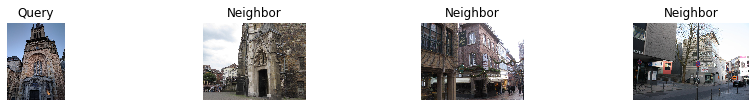

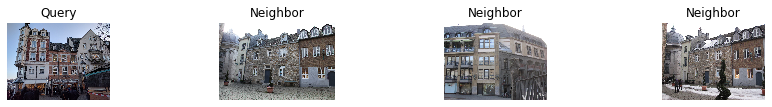

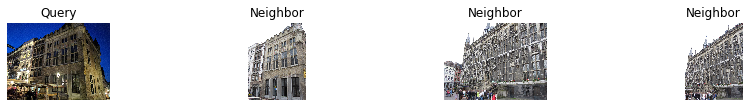

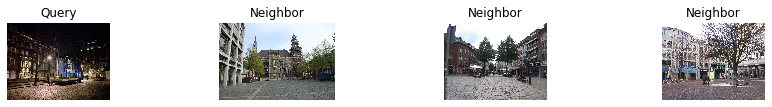

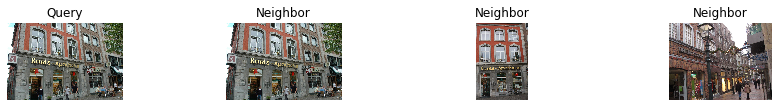

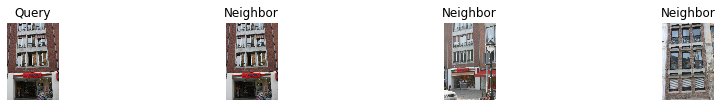

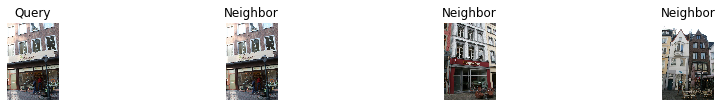

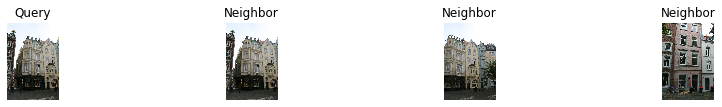

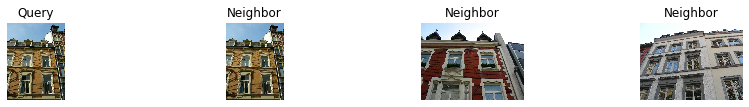

In [21]:
for i, query_img in enumerate(query_imgs_high_res):
    imgs = [query_img] 
    imgs = imgs + [get_img(image_ids[j]) for j in indices[i]]
    fig = plt.figure(figsize=(15,15))
    #plt.title('Neighbors')
    for j, img in enumerate(imgs):
        a = fig.add_subplot(n_queries, n_images+1, i*(n_images+1)+j+1)
        plt.imshow(img)
        if j > 0:
            plt.title('Neighbor')#'%.0f'%distances[i][j-1])
        else:
            plt.title('Query')
        plt.axis('off')
    plt.show()

## 2. Covisibility clustering

In [23]:
query_id = 8

In [24]:
## convert indices to colmap indices
#indices_colmap = np.array([get_img_id_dataset(database_cursor, xii) for xi in indices for xii in xi]).reshape(indices.shape)

In [26]:
cluster_query = [img_cluster[image_ids[indices[query_id][0]]]]
cluster_orig_ids = [image_ids[indices[query_id][0]]]
for i, ind in enumerate(indices[query_id]):
    ind = image_ids[ind]
    if i == 0:
        continue
    point_set = img_cluster[ind]
    print('Match neighbor %d'%i)
    disjoint = False
    for j, c in enumerate(cluster_query):
        if ind in c:
            print('  - Can be matched to cluster')
            #print(point_set - (point_set-cluster))
            cluster_query[j] |= point_set
            disjoint = True
            break
    if not disjoint:
        print('  - New cluster created')
        cluster_orig_ids.append(ind)
        cluster_query.append(point_set)

Match neighbor 1
  - New cluster created
Match neighbor 2
  - New cluster created


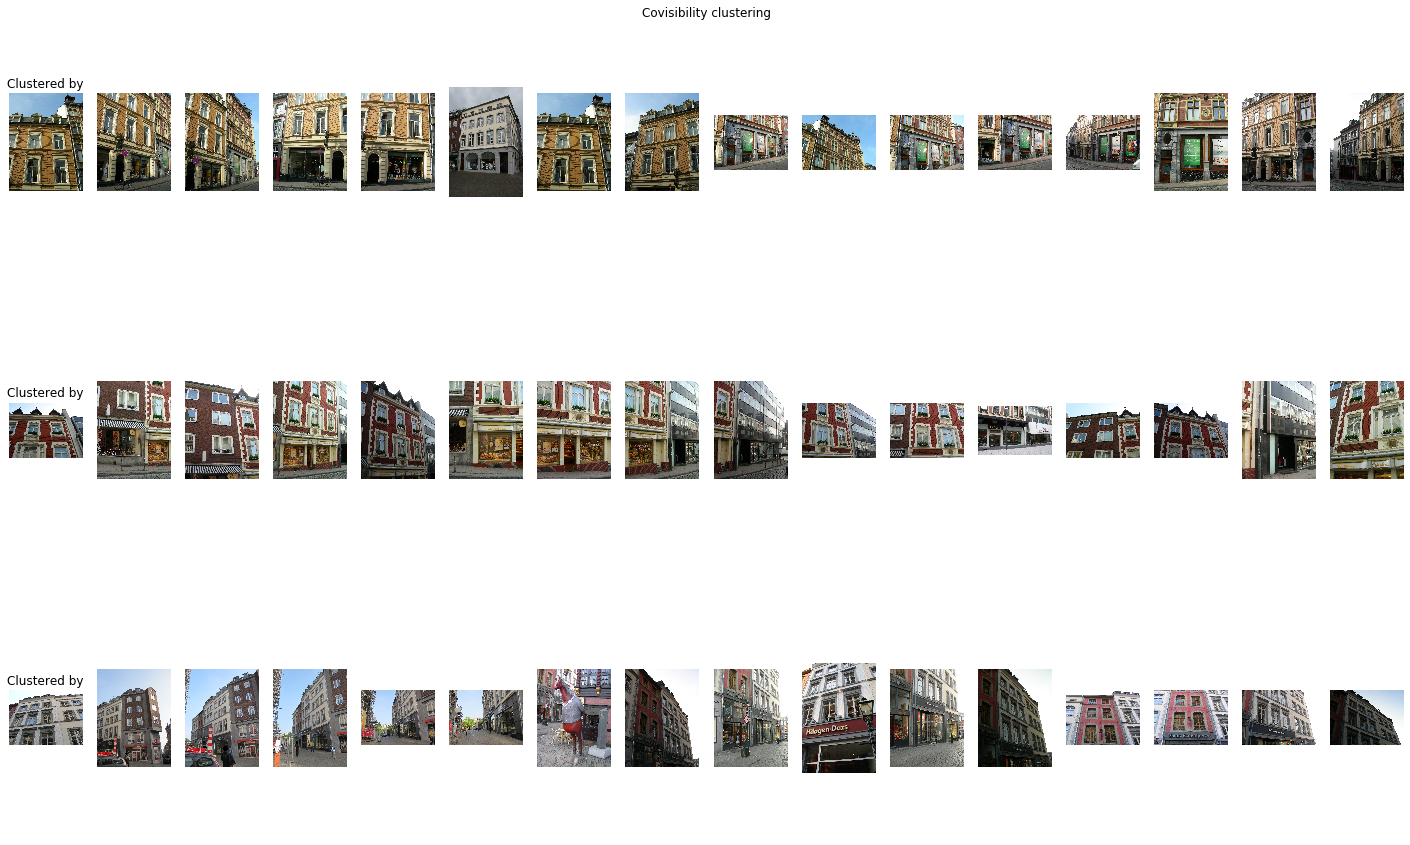

In [27]:
num_imgs_per_cluster = 15
fig = plt.figure(figsize=(25,15))
plt.title('Covisibility clustering')
plt.axis('off')
for i, cluster in enumerate(cluster_query):
    imgs = list(cluster_query[i])[:num_imgs_per_cluster]
    imgs = [get_img(cluster_orig_ids[i])]+[get_img(j) for j in imgs]
    for j, img in enumerate(imgs):
        a = fig.add_subplot(len(cluster_query), len(imgs), i*len(imgs)+j+1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title('Clustered by')
plt.show()

In [28]:
cluster_points = []
for i, c in enumerate(cluster_query):
    imgs_cluster = list(c)
    points_cluster = set()
    for ind in imgs_cluster:
        pt_ids = images[ind].point3D_ids
        valid = pt_ids > 0
        points_cluster |= set(pt_ids[valid])
    points_cluster = list(points_cluster)
    cluster_points.append(np.stack([points3d[x].xyz for x in points_cluster]))
    """mask = np.ones(len(points3d),dtype=bool) #np.ones_like(a,dtype=bool)
    mask[points_cluster] = False

    cluster_points.append(points3d[~mask])"""
    print('%d\tpoints in cluster'%cluster_points[i].shape[0])
#other_points = points[mask]
#print('%d other points'%other_points.shape[0])

9147	points in cluster
16445	points in cluster
30152	points in cluster


Median is [ 7.99133855e+02  5.25809648e-02 -1.44500216e+02]


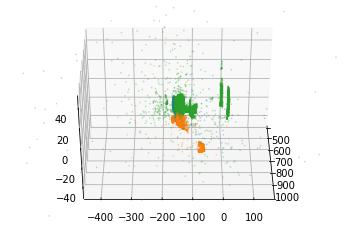

In [29]:
thresh = 300
ax = plt.axes(projection='3d')
#ax.scatter3D(other_points[:,0], other_points[:,2], other_points[:,1], s = 0.5, alpha = 0.01)
for cp in cluster_points:
    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
median = np.sum([np.median(cp, axis=0)*cp.shape[0] for cp in cluster_points], axis=0)/float(sum([cp.shape[0] for cp in cluster_points]))
print('Median is %s'%median)
ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()

## 3. Find local descriptors

In [30]:
test_id = cluster_orig_ids[0] #197

<b> Order to get image - keypoint - 3D point correspondances: </b>
1. take image
2. find image name
3. find db_id of image_name
4. get keypoints
5. get valid 3d points

db/4000.jpg
len kpts: 435


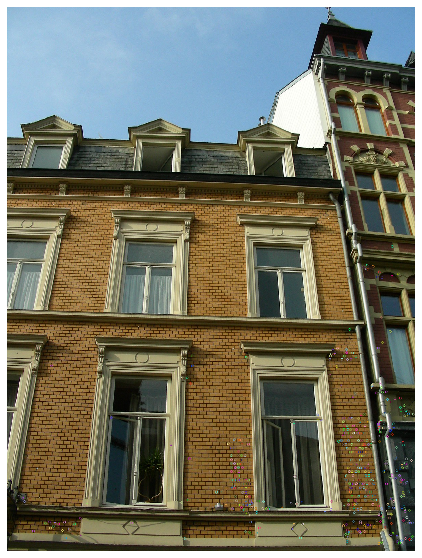

(435,)
435
10087
(435, 128)


In [31]:
test_id = cluster_orig_ids[0]
db_id = test_id#get_img_id_dataset(database_cursor, test_id)
img_name = images[db_id].name
neighbor_img_original = np.array(load_image('data/AachenDayNight/images_upright/'+img_name))
print(img_name)
valid = images[db_id].point3D_ids > 0 
#print([i for i in range(len(valid)) if valid[i]])
neighbor_kpts, neighbor_desc = get_kpts_desc(database_cursor, db_id)
neighbor_kpts = kpts_to_cv(neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5)
pt_ids = images[db_id].point3D_ids[valid]
print('len kpts: %d'%len(neighbor_kpts))
plt.figure(figsize=(10,10))
neighbor_img = cv2.drawKeypoints(neighbor_img_original,neighbor_kpts, None)
plt.imshow(neighbor_img)
plt.axis('off')
plt.show()
neighbor_desc = neighbor_desc[valid[:neighbor_desc.shape[0]]]
#print(images[db_id])
print(pt_ids.shape)
print(len(neighbor_kpts))
print(len(valid)//2)
print(neighbor_desc.shape)

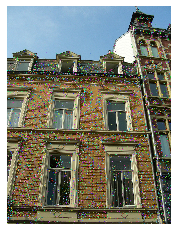

In [32]:
if query_id < 4:
    test_query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/query/', '')
    print(test_query_path)
    query_img_id = get_img_id(query_cursor, test_query_path)
    query_kpts, query_desc = get_kpts_desc(query_cursor, query_img_id)
else:
    fake_query_path = 'db/'+path_to_queries[query_id].split('/')[-1]
    query_kpts, query_desc = get_kpts_desc(database_cursor, get_img_id(database_cursor,fake_query_path))
    
query_kpts = kpts_to_cv(query_kpts)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts, None)
plt.imshow(query_img)
plt.axis('off')
plt.show()

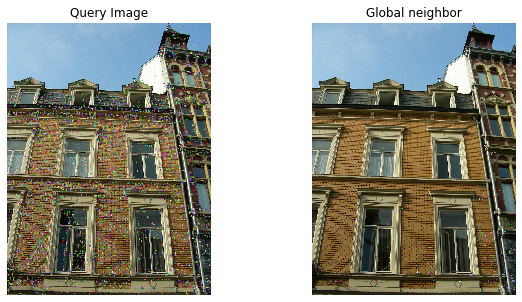

In [33]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title('Query Image')
a = fig.add_subplot(1,2,2)
plt.imshow(neighbor_img)
plt.axis('off')
plt.title('Global neighbor')
plt.show()

In [34]:
t = time.time()
matcher = cv2.BFMatcher.create(cv2.NORM_L2)
print(query_desc.shape)
print(neighbor_desc.shape)
matches = matcher.knnMatch(neighbor_desc, query_desc, k=2)
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        #matchesMask[i]=[1,0]
        good.append(m)
#m = m[matchesMask]
matches = good
        
t = time.time() - t
print('Matching took %d seconds\nFound %d matches'%(t, len(matches)))

(10087, 128)
(435, 128)
Matching took 0 seconds
Found 435 matches


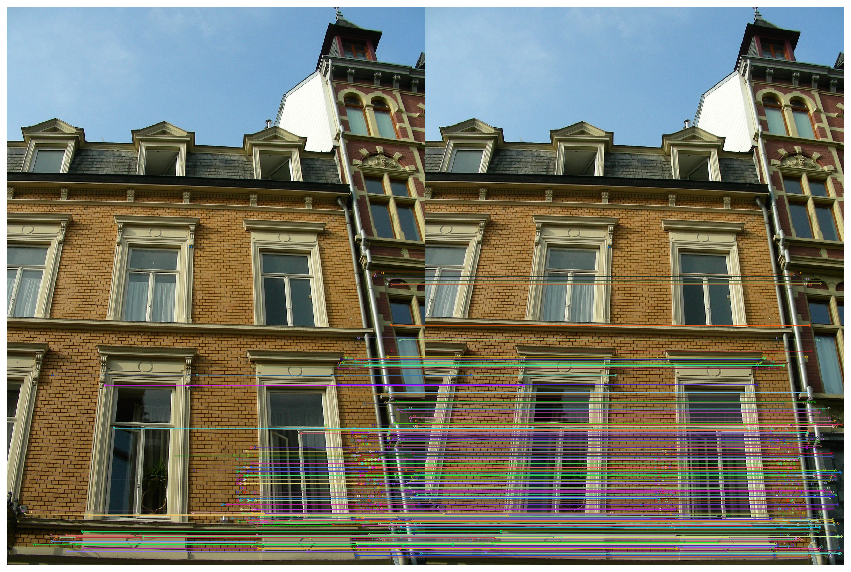

In [35]:
# cv2.drawMatchesKnn expects list of lists as matches.
#draw_params = dict(matchColor = (0,255,0),
#                   singlePointColor = (255,0,0),
#                   matchesMask = matchesMask,
#                   flags = 2)
img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(neighbor_img_original,neighbor_kpts,np.array(query_imgs_high_res[query_id]),query_kpts,matches,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.axis('off')
plt.show()

In [36]:
##settings
ratio_thresh = 0.9# 0.75


t = time.time()
matched_kpts_cv = []
matched_pts = []
matcher = cv2.BFMatcher.create(cv2.NORM_L2)
print('Start')
for c in cluster_query:
    for img in c:
        db_id = img # get_img_id_dataset(database_cursor, img)
        img_name = images[db_id].name
        valid = images[db_id].point3D_ids > 0 
        data_kpts, data_desc = get_kpts_desc(database_cursor, db_id)
        data_kpts = kpts_to_cv(data_kpts[valid[:data_kpts.shape[0]]] - 0.5)
        pt_ids = images[db_id].point3D_ids[valid]
        data_desc = data_desc[valid[:data_desc.shape[0]]]
        
        matches = matcher.knnMatch(data_desc, query_desc, k=2)
        good = []
        for i,(m,n) in enumerate(matches):
            if m.distance < ratio_thresh*n.distance:
                good.append(m)
        matched_kpts_cv += [query_kpts[i] for i in [g.trainIdx for g in good]]
        matched_pts += [pt_ids[i] for i in [g.queryIdx for g in good]]
        print('.',end='')
t = time.time() - t
print('\nTotal matching time: %d seconds'%t)

Start
..................................................................................................................
Total matching time: 26 seconds


In [37]:
matched_pts_xyz = np.stack([points3d[i].xyz for i in matched_pts])
print(matched_pts_xyz.mean(axis=0))
print(matched_pts_xyz.shape)

[ 800.22933022    0.85180127 -141.963247  ]
(12861, 3)


In [38]:
matched_keypoints = np.vstack([np.array([x.pt[0], x.pt[1]]) for x in matched_kpts_cv])
print(matched_keypoints.shape)

(12861, 2)


## 5. Calculate pose

In [39]:
query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/', '')
cm = camera_matrices[query_path]
camera_matrix = cm['cameraMatrix']
distortion_coeff = cm['rad_dist']
print(camera_matrix)
print(distortion_coeff)

[[1.83747e+03 0.00000e+00 6.00000e+02]
 [0.00000e+00 1.83747e+03 8.00000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
-0.163611


In [40]:
n_iter = 5000

In [41]:
t = time.time()
success, R_vec, translation, inliers = cv2.solvePnPRansac(
        matched_pts_xyz, matched_keypoints, camera_matrix, np.array([distortion_coeff, 0, 0, 0]),
        iterationsCount=n_iter, reprojectionError=8.,
        flags=cv2.SOLVEPNP_P3P)
t = time.time() - t
print('PnP RANSAC took %d seconds (%.2f/iteration)'%(t, float(t)/float(n_iter)))

PnP RANSAC took 1 seconds (0.00/iteration)


In [42]:
if success:
    print('Successful matching')
    print(inliers.shape)
else:
    print('Not succesful')
print(R_vec)
print(translation)


Successful matching
(1534, 1)
[[ 0.95023799]
 [-0.87715909]
 [-2.6172896 ]]
[[538.59300397]
 [392.53363481]
 [524.18107144]]


In [43]:
print(matched_pts_xyz[inliers].shape)
print(matched_keypoints[inliers].shape)

(1534, 1, 3)
(1534, 1, 2)


In [44]:
min_inliers = 10

if success:
    inliers = inliers[:, 0] if len(inliers.shape) > 1 else inliers
    num_inliers = len(inliers)
    inlier_ratio = len(inliers) / len(matched_keypoints)
    success &= num_inliers >= min_inliers

    ret, R_vec, t = cv2.solvePnP(
                matched_pts_xyz[inliers], matched_keypoints[inliers], camera_matrix,
                dist_vec, rvec=R_vec, tvec=translation, useExtrinsicGuess=True,
                flags=cv2.SOLVEPNP_ITERATIVE)
    assert ret

    query_T_w = np.eye(4)
    query_T_w[:3, :3] = cv2.Rodrigues(R_vec)[0]
    query_T_w[:3, 3] = t[:, 0]
    w_T_query = np.linalg.inv(query_T_w)

    #ret = LocResult(success, num_inliers, inlier_ratio, w_T_query)

In [45]:
#print(w_T_query)
print('Result: \t%s'%w_T_query[:3, 3])
if query_id > 3:
    #pose_stats_filename = os.path.join('data/AachenDayNight/', 'pose_stats.txt')
    #mean_t, std_t = np.loadtxt(pose_stats_filename)
    #position = dataset[dataset_queries[query_id-4]][1][:3]
    #position = position*std_t + mean_t
    position = colmap_image_to_pose(images[get_img_id(database_cursor, fake_query_path)])[:3,3]
    error = np.linalg.norm(position-w_T_query[:3,3])
    error_str = '%.1f m'%error if error > 1e-1 else '%.1f cm'%(100.0*error)
    print('Groundtruth: \t%s \nError: \t\t%s'%(str(position), error_str))


Result: 	[ 833.52299664   -6.03689841 -155.51360222]
Groundtruth: 	[ 833.52679961   -6.03329158 -155.51506947] 
Error: 		0.5 cm


## old code




In [ ]:
## stop notebook run all
1.0/0.0

In [ ]:
## Now all clusters
t = time.time()
kpts_des = {}
place_lms = []
for c in cluster_query:
    for img in c:
        kpts = []
        point_ids = measurements[img]['point_id']
        place_lms += point_ids
        for i, kpt in enumerate(measurements[img]['kpts']):
            kpts.append(cv2.KeyPoint(kpt[0], kpt[1], _size=med_kpt_size))
        if len(kpts) <= 0:
            continue
        kpts_des[img] = sift.compute(np.array(dataset[img][0]), kpts)
place_lms = np.array(place_lms)
t = time.time() - t
print('Took %d seconds'%t)

In [ ]:
random_id = list(cluster_query[0])[12]
plt.imshow(cv2.drawKeypoints(np.array(dataset[random_id][0]),kpts_des[random_id][0], None))
plt.show()

In [ ]:
print(len(kpts_des))
print(sum([len(c) for c in cluster_query]))
print(place_lms.shape)
print(kpts_des[random_id][1].shape)

In [ ]:
"""
From https://github.com/ethz-asl/hfnet
"""

def matches_cv2np(matches_cv):
    matches_np = np.int32([[m.queryIdx, m.trainIdx] for m in matches_cv])
    distances = np.float32([m.distance for m in matches_cv])
    return matches_np.reshape(-1, 2), distances

query_des = query_des.astype(np.float32, copy=False)
dataset_des = np.concatenate([kpts_des[x][1] for x in kpts_des]).astype(np.float32, copy=False)
#img_match_ids = [x for i in range(len(kpts_des[x][1])) for x in kpts_des]
#print(len(img_match_ids))


print(type(query_des))
print(type(dataset_des))
print(query_des.shape)
print(dataset_des.shape)

matcher = cv2.BFMatcher(cv2.NORM_L2)
m = matcher.knnMatch(dataset_des, query_des, k=2)

matches1, matches2 = list(zip(*m))
(matches1, dist1) = matches_cv2np(matches1)
(matches2, dist2) = matches_cv2np(matches2)
print(matches1.shape)
print(matches2.shape)
print('Done matching: %d matches'%len(m))

In [ ]:
ratio_thresh = 0.70
#print(matches1[:5])
#print(matches2[:5])
#print(matches1[103])

In [ ]:
print(place_lms.shape)
## Index testing cannot work as we do not know which points are in query (problem would be already solved)
#good = (place_lms[matches1[:, 1]] == place_lms[matches2[:, 1]])
good = (dist1/dist2 < ratio_thresh)
matches_good = matches1[good]

In [ ]:
print(good[:10])
print(matches_good[0])
#print(len([g for g in good if not g]))
#print(len(matches))

In [ ]:
cnt = 0
img_shown = 0
for c in cluster_query:
    for img in c:
        kpt = kpts_des[img][0]
        n = len(kpt)
        cnt += n
        print('%d:%d'%(cnt-n,cnt))
        if not np.any(good[cnt-n:cnt]):
            continue
        
        img_shown += 1
        if img_shown > 5:
            break
        #matches_img = [i for x in m[cnt-n:cnt] for i in x if x[0].distance < ratio_thresh*x[1].distance]
        matches_img = [cv2.DMatch()]
        data_img = np.array(dataset[img][0])
        img3 = np.empty((max(query_sift_img.shape[0], data_img.shape[0]), query_sift_img.shape[1] + data_img.shape[1], 3), dtype=np.uint8)
        cv2.drawMatches(data_img,kpt,query_img,query_kpts,matches_img,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
        plt.imshow(img3)
        plt.axis('off')
        plt.show()

In [ ]:
matched_points = np.stack([points[place_lms[i]] for i in matches[:, 0]])
matched_kpts = np.vstack([np.array(query_kpts[i].pt) for i in matches[:, 1]])

In [ ]:
print(matched_points.shape)
print(matched_kpts.shape)

In [ ]:
thresh = 300
ax = plt.axes(projection='3d')
ax.scatter3D(matched_points[:,0], matched_points[:,2], matched_points[:,1], s = 1.5, alpha = 0.5)
#for cp in cluster_points:
#    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
#ax.scatter3D(translation[0], translation[2], translation[1], s=25, alpha=1.0)
median = np.median(points, axis=0)
print('Median is %s'%median)
#ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
#ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
#ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()